In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class PortfolioMDP:
    def __init__(self, increment_step=5):  # Decrease increment_step to get more granular states
        # States: [(stocks%, bonds%, cash%), market_condition, years_left]
        # Market condition: 0 = bearish, 1 = neutral, 2 = bullish
        # Years left is discretized into 0-5, 5-10, >10
        self.states = [(stocks, bonds, 100-stocks-bonds, mc, yl) 
                       for stocks in range(0, 101, increment_step) 
                       for bonds in range(0, 101, increment_step) 
                       if stocks + bonds <= 100
                       for mc in range(3) 
                       for yl in range(3)]
        self.action_space = ['increase_stocks', 'decrease_stocks', 'increase_bonds', 'decrease_bonds', 'hold']
        self.current_state = (50, 30, 20, 1, 2)  # Example initial state
        self.reward = 0

    def step(self, action):
        stocks, bonds, cash, market_condition, years_left = self.current_state
        if action == 'increase_stocks' and cash >= increment_step:
            stocks += increment_step
            cash -= increment_step
        elif action == 'decrease_stocks' and stocks >= increment_step:
            stocks -= increment_step
            cash += increment_step
        elif action == 'increase_bonds' and cash >= increment_step:
            bonds += increment_step
            cash -= increment_step
        elif action == 'decrease_bonds' and bonds >= increment_step:
            bonds -= increment_step
            cash += increment_step
        # Simulate market condition change and years passing
        market_condition = np.random.choice(range(3))
        years_left = max(0, years_left - 1)
        
        self.current_state = (stocks, bonds, cash, market_condition, years_left)
        self.reward = self.calculate_reward()
        return self.current_state, self.reward

    def calculate_reward(self):
        # Simplified reward calculation
        stocks, bonds, cash, market_condition, _ = self.current_state
        # Example reward function: value increase + penalty for low cash
        reward = stocks * (0.1 if market_condition == 2 else -0.05) + bonds * (0.05 if market_condition > 0 else -0.02)
        reward -= 5 if cash < increment_step else 0
        return reward

# Example usage
increment_step = 5  # Decrease this value to increase the number of states
mdp = PortfolioMDP(increment_step)
new_state, reward = mdp.step('increase_stocks')
print(f"New State: {new_state}, Reward: {reward}")


New State: (55, 30, 15, 1, 1), Reward: -1.25


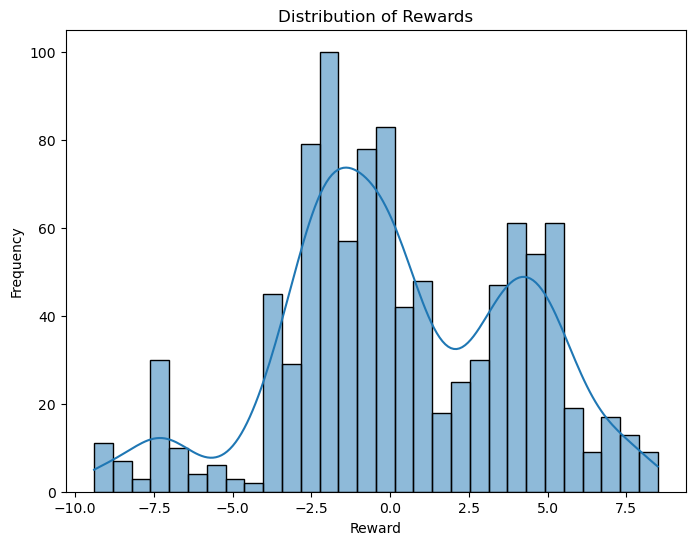

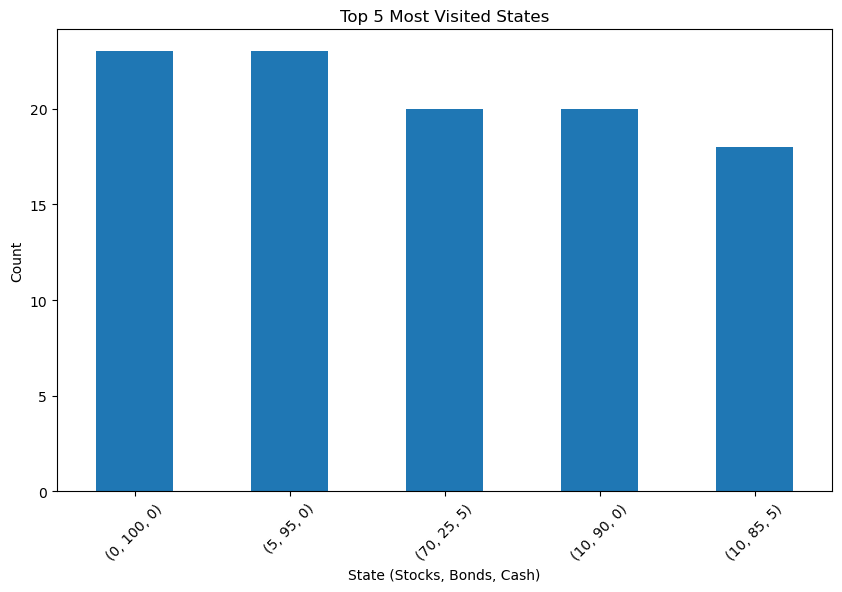

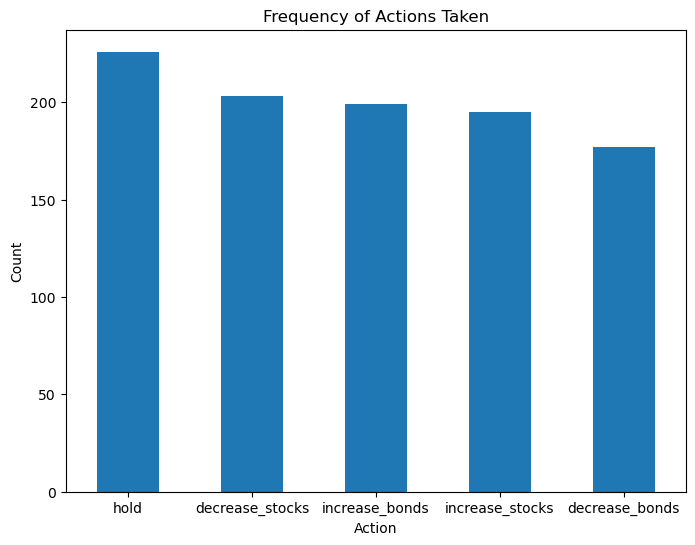

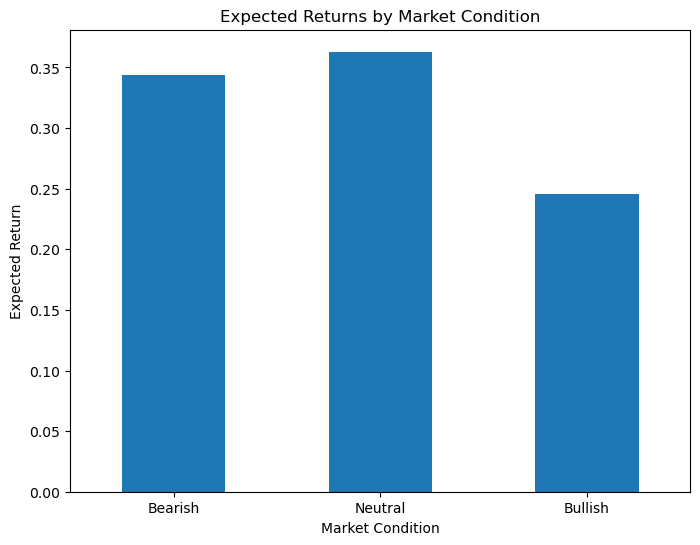

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize MDP and simulate
increment_step = 5  # The same increment_step used in the previous cell
mdp = PortfolioMDP(increment_step)
n_simulations = 1000  # Number of simulations

transitions = []  # List to store state transitions

for _ in range(n_simulations):
    action = np.random.choice(mdp.action_space)
    old_state = mdp.current_state
    new_state, reward = mdp.step(action)
    transitions.append((old_state, action, new_state, reward))

# Convert transitions to a DataFrame for analysis
df_transitions = pd.DataFrame(transitions, columns=['Old State', 'Action', 'New State', 'Reward'])

# Plot a Reward Distribution Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_transitions['Reward'], bins=30, kde=True)
plt.title('Distribution of Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

# Extract states and counts for the Top 5 Most Visited States
state_visits = df_transitions['Old State'].apply(lambda x: (x[0], x[1], x[2])).value_counts().head(5)
plt.figure(figsize=(10, 6))
state_visits.plot(kind='bar')
plt.title('Top 5 Most Visited States')
plt.xlabel('State (Stocks, Bonds, Cash)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot a Bar Chart of Actions Taken
actions_taken = df_transitions['Action'].value_counts()
plt.figure(figsize=(8, 6))
actions_taken.plot(kind='bar')
plt.title('Frequency of Actions Taken')
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# To plot Expected Returns by Market Condition, we'll need to extract the market condition from each state
df_transitions['Market Condition'] = df_transitions['Old State'].apply(lambda x: x[3])
expected_returns = df_transitions.groupby('Market Condition')['Reward'].mean()

plt.figure(figsize=(8, 6))
expected_returns.plot(kind='bar')
plt.title('Expected Returns by Market Condition')
plt.xlabel('Market Condition')
plt.ylabel('Expected Return')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish', 'Neutral', 'Bullish'], rotation=0)
plt.show()


In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class VectorizedPortfolioMDP:
    def __init__(self, n_states=10, n_market_conditions=3, years_range=(0, 10)):
        self.n_states = n_states  # Simplification for example purposes
        self.n_market_conditions = n_market_conditions
        self.years_range = years_range
        # Assuming simplified state space for demonstration
        self.states = np.array(np.meshgrid(np.linspace(0, 100, n_states), 
                                           np.linspace(0, 100, n_states), 
                                           np.linspace(*years_range, n_states),
                                           np.arange(n_market_conditions))).T.reshape(-1, 4)
        self.gamma = 0.95
        self.state_values = np.zeros(len(self.states))
        self.policy = np.zeros(len(self.states), dtype=int)

    def calculate_reward(self, action, state):
        # Simplified reward calculation
        stocks, bonds, years_left, market_condition = state
        # Example actions encoded as integers for vectorization
        if action == 0:  # 'hold'
            return -1  # Encourage activity
        elif action == 1:  # 'increase_stocks'
            return stocks * (0.1 if market_condition == 2 else -0.05)
        elif action == 2:  # 'decrease_stocks'
            return -stocks * (0.1 if market_condition == 2 else 0.05)
        # Add more actions as needed
        return 0

    def value_iteration(self, epsilon=0.01):
        delta = float('inf')
        self.delta_history = []  # Track changes in delta for convergence plot
        while delta > epsilon:
            delta = 0
            for i, state in enumerate(self.states):
                v = self.state_values[i]
                rewards = np.array([self.calculate_reward(a, state) for a in range(3)])  # Assuming 3 actions
                max_reward = np.max(rewards)
                new_value = max_reward + self.gamma * v
                delta = max(delta, np.abs(v - new_value))
                self.state_values[i] = new_value
                self.policy[i] = np.argmax(rewards)
            self.delta_history.append(delta)  # Add delta to history for plotting
            print(f"Iteration complete with delta: {delta}")

# Example usage
mdp = VectorizedPortfolioMDP()
mdp.value_iteration()
print("Value iteration completed.")


Iteration complete with delta: 10.0
Iteration complete with delta: 9.5
Iteration complete with delta: 9.024999999999999
Iteration complete with delta: 8.573749999999997
Iteration complete with delta: 8.145062500000002
Iteration complete with delta: 7.737809374999998
Iteration complete with delta: 7.350918906250001
Iteration complete with delta: 6.983372960937494
Iteration complete with delta: 6.634204312890631
Iteration complete with delta: 6.302494097246097
Iteration complete with delta: 5.987369392383783
Iteration complete with delta: 5.688000922764601
Iteration complete with delta: 5.403600876626371
Iteration complete with delta: 5.1334208327950535
Iteration complete with delta: 4.876749791155291
Iteration complete with delta: 4.632912301597528
Iteration complete with delta: 4.401266686517658
Iteration complete with delta: 4.181203352191773
Iteration complete with delta: 3.9721431845821797
Iteration complete with delta: 3.7735360253530814
Iteration complete with delta: 3.58485922408

Value Iteration converged in 136 iterations.


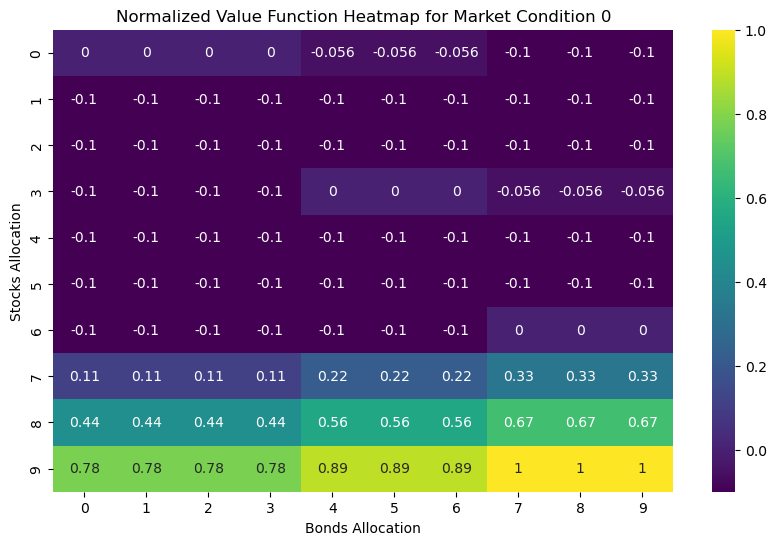

<Figure size 1000x600 with 0 Axes>

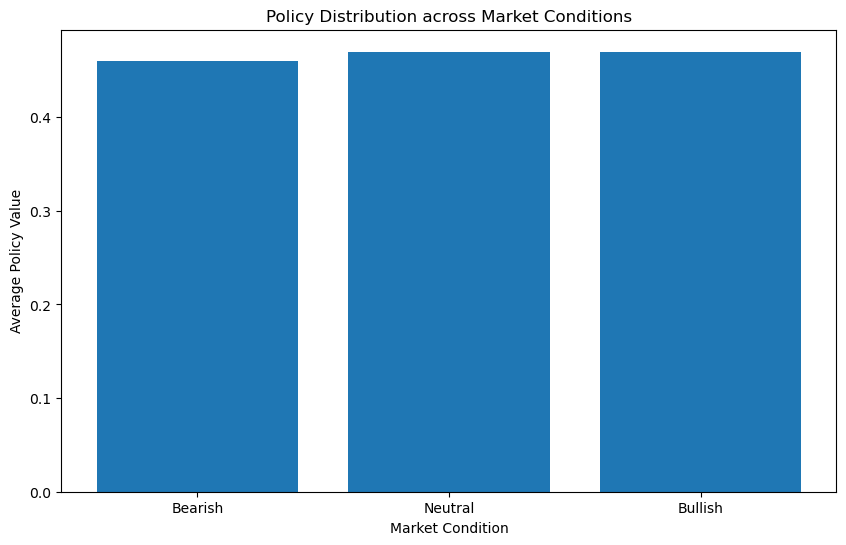

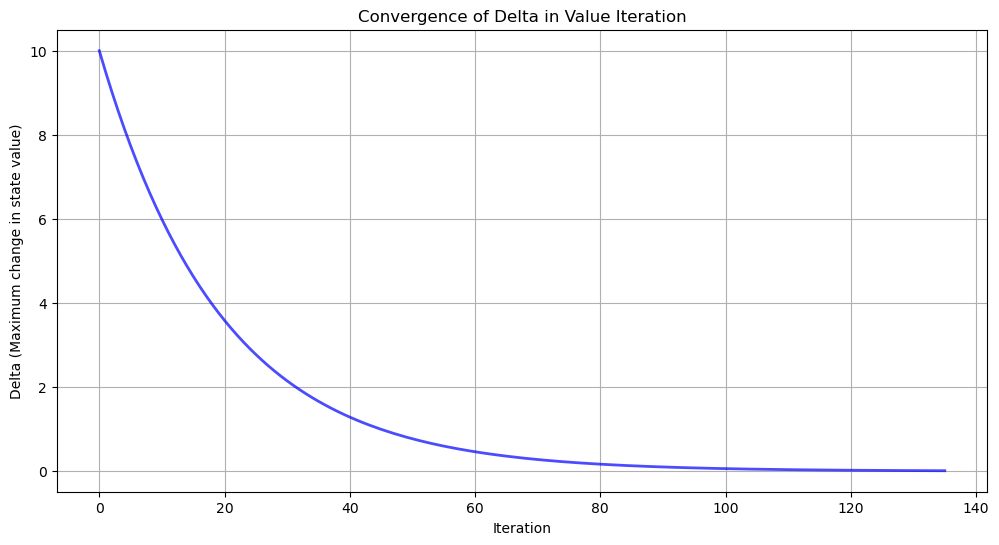

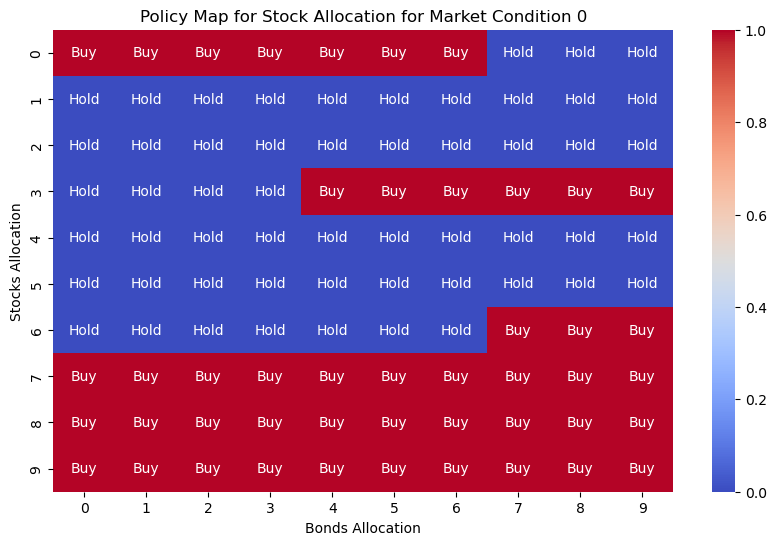

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class PortfolioMDP:
    def __init__(self, n_states=10, n_market_conditions=3):
        self.n_states = n_states
        self.n_market_conditions = n_market_conditions
        # Define your states properly with relevant parameters
        self.states = np.array(np.meshgrid(np.linspace(0, 100, n_states), 
                                           np.linspace(0, 100, n_states), 
                                           np.arange(n_market_conditions))).T.reshape(-1, 3)
        self.gamma = 0.95
        self.state_values = np.zeros(len(self.states))
        self.policy = np.zeros(len(self.states), dtype=int)
        self.iteration_rewards = []
        self.delta_history = []

    def calculate_reward(self, action, state):
        # Define your rewards here based on action and state
        stocks, bonds, market_condition = state
        if action == 0:  # Hold
            return -1  # Penalize holding
        elif action == 1:  # Increase stocks
            return stocks * (0.1 if market_condition == 2 else -0.05)
        elif action == 2:  # Decrease stocks
            return -stocks * (0.1 if market_condition == 2 else 0.05)
        return 0

    def value_iteration(self, epsilon=0.01):
        delta = float('inf')
        iteration = 0
        while delta > epsilon:
            delta = 0
            for i, state in enumerate(self.states):
                v = self.state_values[i]
                rewards = np.array([self.calculate_reward(a, state) for a in range(3)])
                max_reward = np.max(rewards)
                self.state_values[i] = max_reward + self.gamma * v
                self.policy[i] = np.argmax(rewards)
                delta = max(delta, np.abs(v - self.state_values[i]))
            self.iteration_rewards.append(max_reward)
            self.delta_history.append(delta)
            iteration += 1
        print(f"Value Iteration converged in {iteration} iterations.")

    def generate_plots(self):
        # Corrected Value Function Heatmap
        values_reshaped = self.state_values.reshape(self.n_states, self.n_states, self.n_market_conditions)
        normalized_values = values_reshaped[:, :, 0] / np.max(values_reshaped)
        plt.figure(figsize=(10, 6))
        sns.heatmap(normalized_values, cmap='viridis', annot=True)
        plt.title('Normalized Value Function Heatmap for Market Condition 0')
        plt.xlabel('Bonds Allocation')
        plt.ylabel('Stocks Allocation')
        plt.show()

        # Corrected Policy Map
        action_labels = {0: 'Hold', 1: 'Increase Stocks', 2: 'Decrease Stocks'}
        policy_labels = np.vectorize(action_labels.get)(self.policy.reshape(self.n_states, self.n_states, self.n_market_conditions)[:, :, 0])
        plt.figure(figsize=(10, 6))

    def generate_additional_plots(self):
        # Expected Returns by Market Condition Plot
        policy_reshaped = self.policy.reshape(self.n_states, self.n_states, self.n_market_conditions)
        avg_policy = np.mean(policy_reshaped, axis=(0, 1))  # Average over state space
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.n_market_conditions), avg_policy)
        plt.title('Policy Distribution across Market Conditions')
        plt.xlabel('Market Condition')
        plt.xticks(range(self.n_market_conditions), ['Bearish', 'Neutral', 'Bullish'])
        plt.ylabel('Average Policy Value')
        plt.show()

        # Convergence Plot
        plt.figure(figsize=(12, 6))
        plt.plot(self.delta_history, color='blue', linewidth=2, alpha=0.7)
        plt.title('Convergence of Delta in Value Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Delta (Maximum change in state value)')
        plt.grid(True)
        plt.show()
                # Policy Map for Stock Allocation for Market Condition 0
        policy_reshaped = self.policy.reshape(self.n_states, self.n_states, self.n_market_conditions)
        policy_for_condition_0 = policy_reshaped[:, :, 0]
        
        # Define the mapping from numeric actions to labels
        action_labels = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
        
        # Convert the numeric policy array to an array of strings using the mapping
        string_policy = np.vectorize(action_labels.get)(policy_for_condition_0)

        # Create a heatmap using the string labels
        plt.figure(figsize=(10, 6))
        sns.heatmap(policy_for_condition_0, annot=string_policy, fmt='', cmap='coolwarm')
        plt.title('Policy Map for Stock Allocation for Market Condition 0')
        plt.xlabel('Bonds Allocation')
        plt.ylabel('Stocks Allocation')
        plt.show()

# Example usage:
mdp = PortfolioMDP(n_states=10, n_market_conditions=3)
mdp.value_iteration()
mdp.generate_plots()
mdp.generate_additional_plots()


Policy Iteration converged to stable policy.


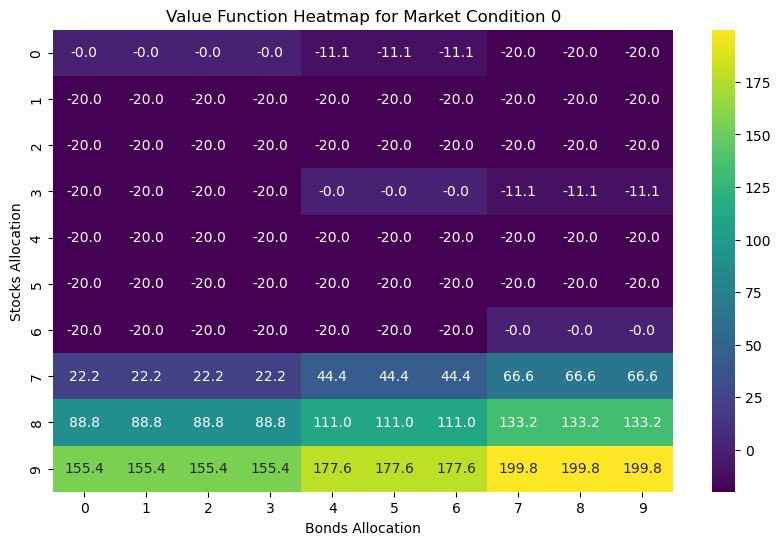

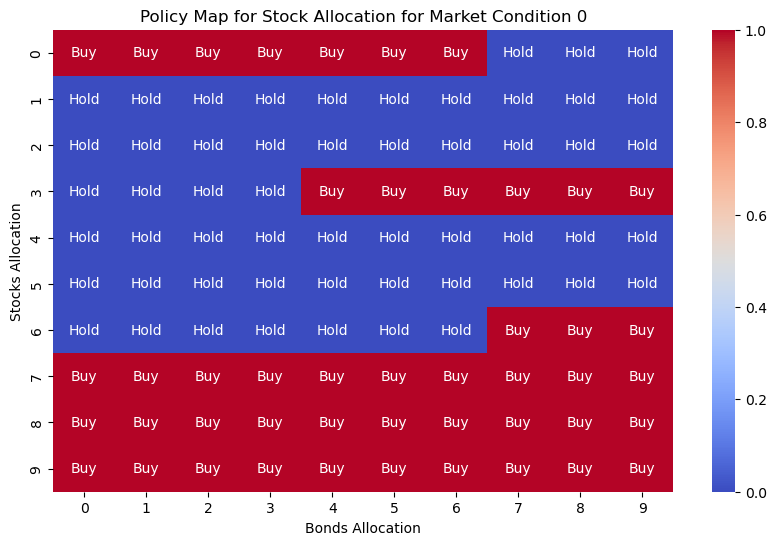

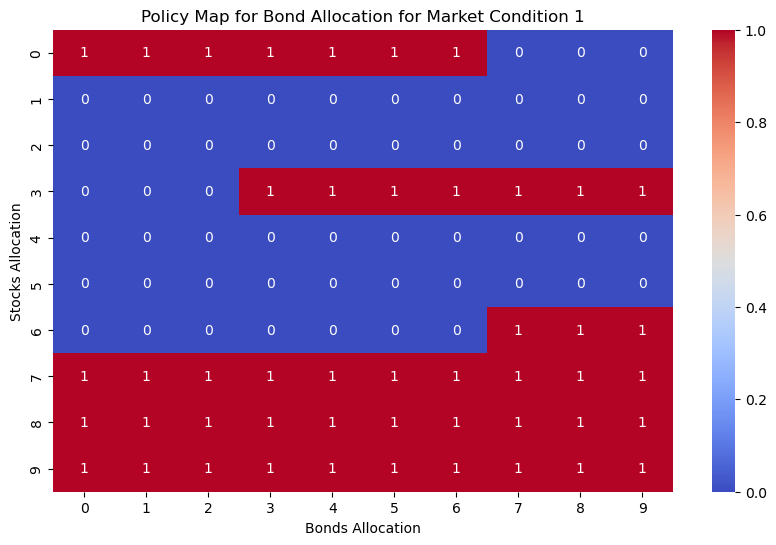

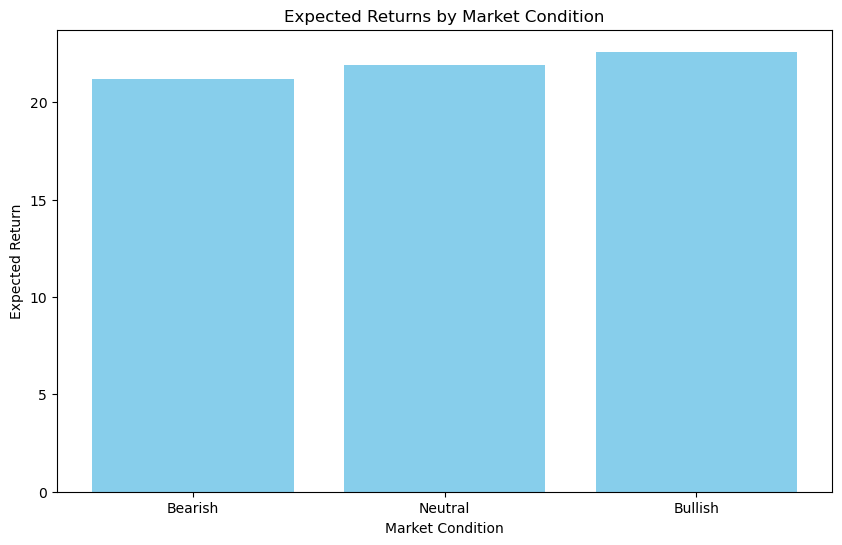

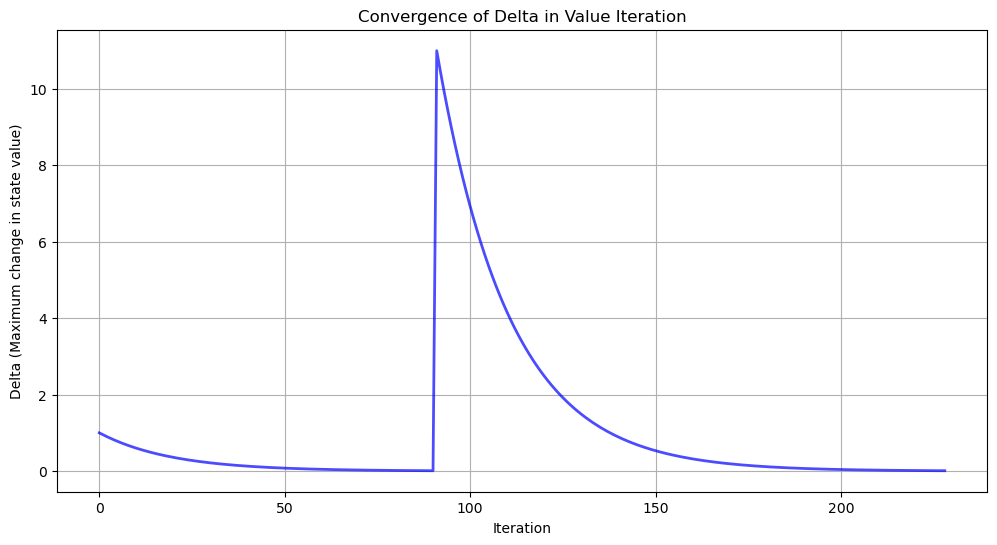

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class PortfolioMDP:
    def __init__(self, n_states=10, n_market_conditions=3):
        self.n_states = n_states
        self.n_market_conditions = n_market_conditions
        self.states = np.array(np.meshgrid(np.linspace(0, 100, n_states), 
                                           np.linspace(0, 100, n_states), 
                                           np.arange(n_market_conditions))).T.reshape(-1, 3)
        self.gamma = 0.95
        self.state_values = np.zeros(len(self.states))
        self.policy = np.zeros(len(self.states), dtype=int)
        self.iteration_rewards = []
        self.delta_history = []

    def calculate_reward(self, action, state):
        stocks, bonds, market_condition = state
        if action == 0:
            return -1
        elif action == 1:
            return stocks * (0.1 if market_condition == 2 else -0.05)
        elif action == 2:
            return -stocks * (0.1 if market_condition == 2 else 0.05)
        return 0

    def policy_evaluation(self, policy, threshold=0.01):
        while True:
            delta = 0
            for i, state in enumerate(self.states):
                v = self.state_values[i]
                action = policy[i]
                reward = self.calculate_reward(action, state)
                self.state_values[i] = reward + self.gamma * v
                delta = max(delta, abs(v - self.state_values[i]))
            self.delta_history.append(delta)
            if delta < threshold:
                break

    def policy_improvement(self):
        policy_stable = True
        for i, state in enumerate(self.states):
            old_action = self.policy[i]
            action_values = np.array([self.calculate_reward(a, state) for a in range(3)])
            best_action = np.argmax(action_values)
            self.policy[i] = best_action
            if old_action != best_action:
                policy_stable = False
        return policy_stable

    def policy_iteration(self):
        policy_stable = False
        while not policy_stable:
            self.policy_evaluation(self.policy)
            policy_stable = self.policy_improvement()
        print("Policy Iteration converged to stable policy.")

    def generate_plots(self):
        value_function = self.state_values.reshape(self.n_states, self.n_states, self.n_market_conditions)[:, :, 0]
        plt.figure(figsize=(10, 6))
        sns.heatmap(value_function, cmap='viridis', annot=True, fmt=".1f")
        plt.title('Value Function Heatmap for Market Condition 0')
        plt.xlabel('Bonds Allocation')
        plt.ylabel('Stocks Allocation')
        plt.show()

        policy_map = self.policy.reshape(self.n_states, self.n_states, self.n_market_conditions)[:, :, 0]
        policy_actions = np.vectorize({0: 'Hold', 1: 'Buy', 2: 'Sell'}.get)(policy_map)  # Map numeric actions to strings
        plt.figure(figsize=(10, 6))
        sns.heatmap(policy_map, cmap='coolwarm', annot=policy_actions, fmt="")
        plt.title('Policy Map for Stock Allocation for Market Condition 0')
        plt.xlabel('Bonds Allocation')
        plt.ylabel('Stocks Allocation')
        plt.show()

    def generate_additional_plots(self):
        policy_matrix = self.policy.reshape(self.n_states, self.n_states, self.n_market_conditions)
        plt.figure(figsize=(10, 6))
        sns.heatmap(policy_matrix[:, :, 1], cmap='coolwarm', annot=True, fmt="d")
        plt.title('Policy Map for Bond Allocation for Market Condition 1')
        plt.xlabel('Bonds Allocation')
        plt.ylabel('Stocks Allocation')
        plt.show()

        market_conditions = np.array([0, 1, 2])
        expected_returns = [np.mean(self.state_values.reshape(self.n_states, self.n_states, self.n_market_conditions)[:, :, mc]) for mc in market_conditions]
        plt.figure(figsize=(10, 6))
        plt.bar(market_conditions, expected_returns, color='skyblue')
        plt.title('Expected Returns by Market Condition')
        plt.xlabel('Market Condition')
        plt.ylabel('Expected Return')
        plt.xticks(market_conditions, ['Bearish', 'Neutral', 'Bullish'])
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.delta_history, color='blue', linewidth=2, alpha=0.7)
        plt.title('Convergence of Delta in Value Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Delta (Maximum change in state value)')
        plt.grid(True)
        plt.show()

# Usage
mdp = PortfolioMDP()
mdp.policy_iteration()
mdp.generate_plots()
mdp.generate_additional_plots()


C:\Users\hoode\AppData\Local\Temp\ipykernel_14412\3590465787.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + self.actions, rotation=90)
C:\Users\hoode\AppData\Local\Temp\ipykernel_14412\3590465787.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + selected_states)


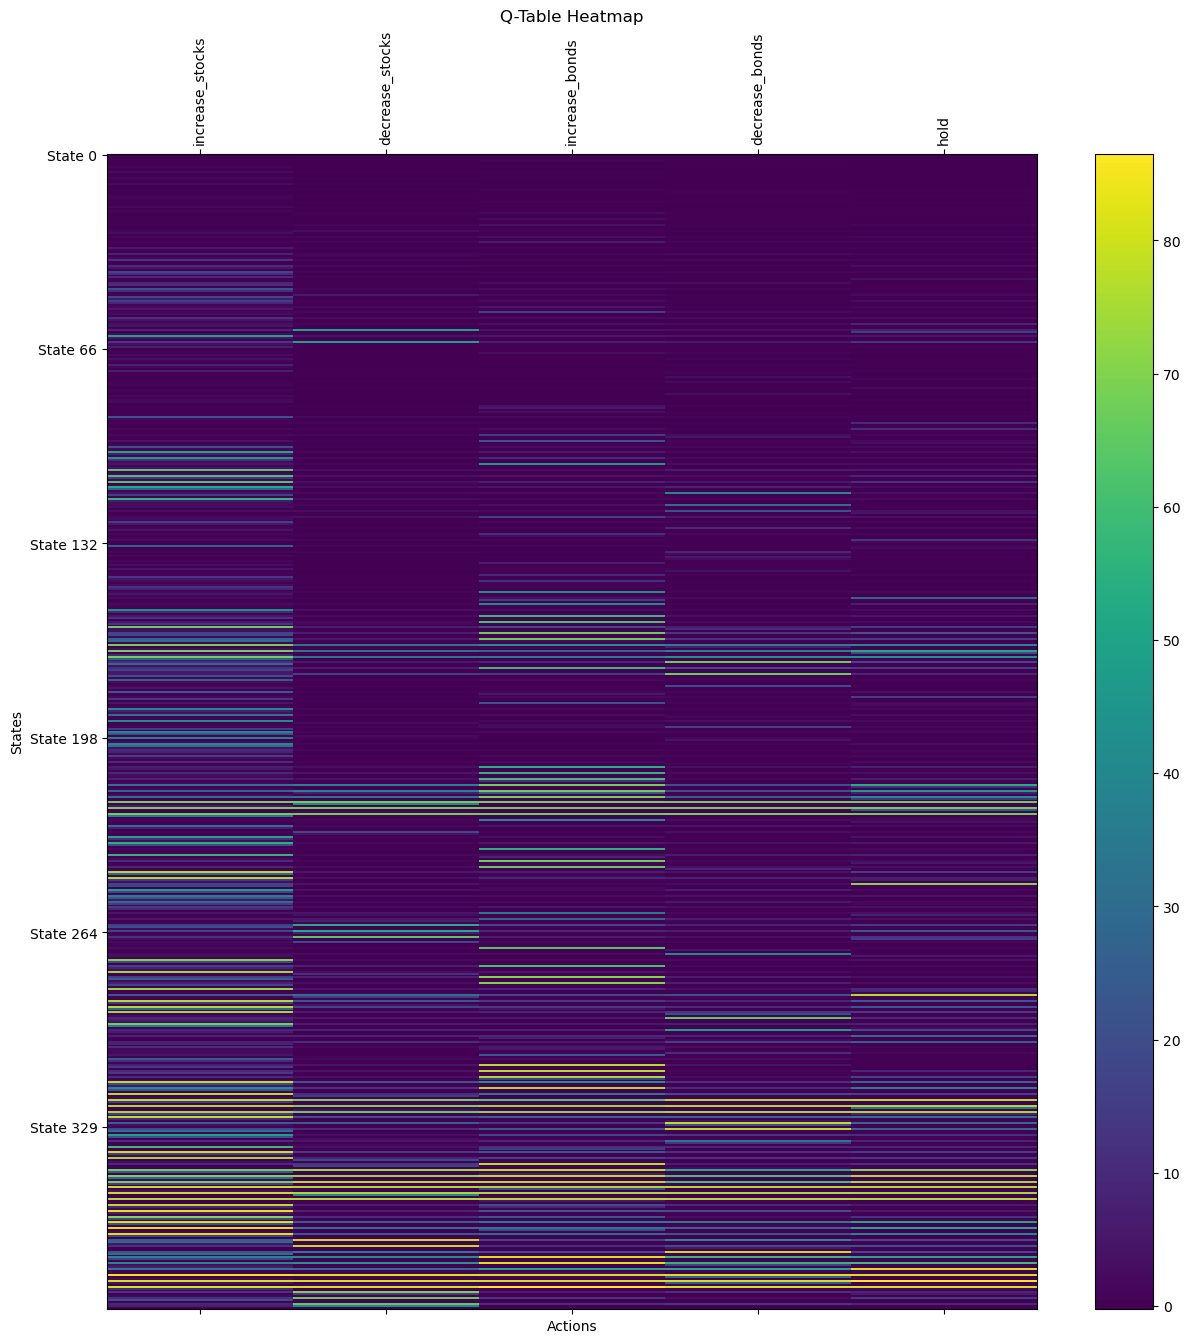

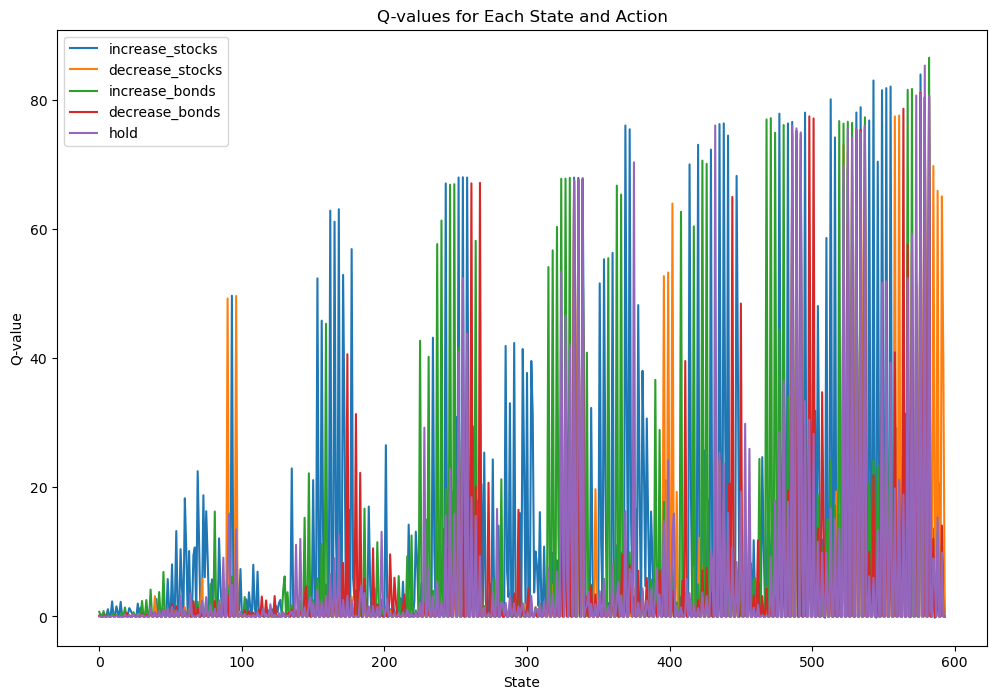

In [88]:
import numpy as np
import random
import matplotlib.pyplot as plt

class PortfolioMDP:
    def __init__(self, num_states=101, num_actions=5, initial_cash=100):
        self.num_states = num_states
        self.num_actions = num_actions
        # Creating a state space of stocks, bonds, and cash allocations, market conditions, and years left
        self.states = [(stocks, bonds, initial_cash - stocks - bonds, mc, yl)
                       for stocks in range(0, num_states, 10)
                       for bonds in range(0, num_states - stocks, 10)
                       for mc in range(3)
                       for yl in range(3)]
        self.actions = ['increase_stocks', 'decrease_stocks', 'increase_bonds', 'decrease_bonds', 'hold']
        self.state_to_index = {self.states[i]: i for i in range(len(self.states))}
        self.q_table = np.zeros((len(self.states), len(self.actions)))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def get_state_index(self, state):
        return self.state_to_index[state]


    def step(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if action == 'increase_stocks' and cash >= 10:
            stocks += 10
            cash -= 10
        elif action == 'decrease_stocks' and stocks >= 10:
            stocks -= 10
            cash += 10
        elif action == 'increase_bonds' and cash >= 10:
            bonds += 10
            cash -= 10
        elif action == 'decrease_bonds' and bonds >= 10:
            bonds -= 10
            cash += 10

        # Simulate market condition and time passing
        market_condition = random.choice([0, 1, 2])
        years_left = max(0, years_left - 1)

        next_state = (stocks, bonds, cash, market_condition, years_left)
        reward = self.calculate_reward(next_state, action)
        return next_state, reward

    def calculate_reward(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if market_condition == 0:  # Bearish
            return stocks * -0.02 + bonds * 0.05
        elif market_condition == 1:  # Neutral
            return stocks * 0.05 + bonds * 0.03
        else:  # Bullish
            return stocks * 0.10 + bonds * 0.01

    def learn(self, episodes=1000, max_steps=100):
        for episode in range(episodes):
            state = random.choice(self.states)  # Start at a random state
            for step in range(max_steps):
                if random.uniform(0, 1) < self.epsilon:
                    action = random.choice(self.actions)  # Explore
                else:
                    state_index = self.get_state_index(state)
                    action = self.actions[np.argmax(self.q_table[state_index])]  # Exploit based on Q table

                next_state, reward = self.step(state, action)
                next_state_index = self.get_state_index(next_state)
                action_index = self.actions.index(action)

                # Q-learning update
                old_value = self.q_table[self.get_state_index(state), action_index]
                next_max = np.max(self.q_table[next_state_index])
                self.q_table[self.get_state_index(state), action_index] = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)

                state = next_state  # Move to the next state

            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

                
    def plot_learning_history(self, delta_history, rewards_history):
        plt.figure(figsize=(12, 6))
        plt.plot(delta_history)
        plt.title('Max Delta per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Max Delta')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(rewards_history)
        plt.title('Total Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()
    def plot_q_table(self):
        # Select a subset of state labels for clarity
        num_display_states = 20  # Choose an appropriate number that keeps the plot readable
        step = len(self.states) // num_display_states
        display_states = range(0, len(self.states), step)
        num_labels = 10  # This is an arbitrary number for demonstration
        selected_indices = np.round(np.linspace(0, len(self.states) - 1, num_labels)).astype(int)
        selected_states = ['State ' + str(i) for i in selected_indices]
        
        # Set up the heatmap without text annotations for clarity
        fig, ax = plt.subplots(figsize=(15, 15))  # You can adjust the size as needed
        cax = ax.matshow(self.q_table, interpolation='nearest', cmap='viridis')
        fig.colorbar(cax)
        
        # Set up the labels
        ax.set_xticklabels([''] + self.actions, rotation=90)
        ax.set_yticklabels([''] + selected_states)
        
        # Adjust the aspect ratio for better visibility
        ax.set_aspect('auto')

        # Set title and labels
        plt.title('Q-Table Heatmap')
        plt.xlabel('Actions')
        plt.ylabel('States')

        plt.show()
        
    def plot_q_values(self):
        # Plot Q-values for each state and action
        plt.figure(figsize=(12, 8))
        for action, action_label in zip(range(self.num_actions), self.actions):
            plt.plot(self.q_table[:, action], label=action_label)
        plt.legend()
        plt.title('Q-values for Each State and Action')
        plt.xlabel('State')
        plt.ylabel('Q-value')
        plt.show()



# Usage
mdp = PortfolioMDP()
mdp.learn(episodes=1000)
mdp.plot_q_table()
mdp.plot_q_values()


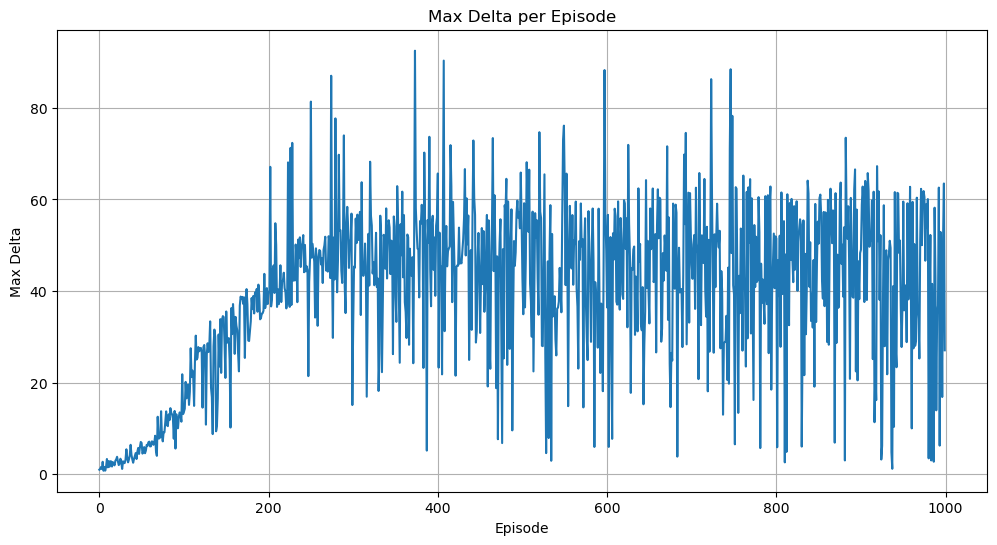

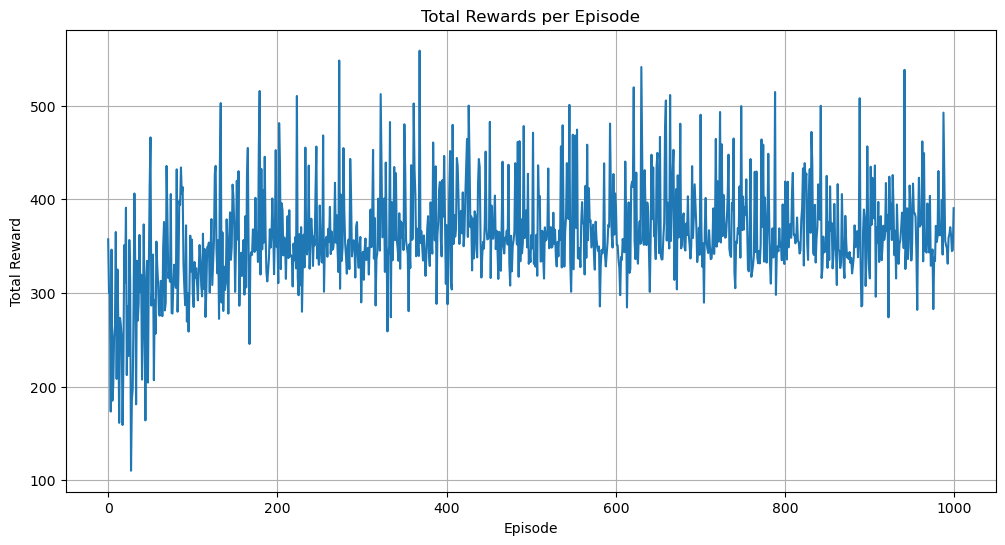

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import random

class PortfolioMDP:
    def __init__(self, num_states=101, num_actions=5, initial_cash=100):
        self.num_states = num_states
        self.num_actions = num_actions
        # Creating a state space of stocks, bonds, cash allocations, market conditions, and years left
        self.states = [(stocks, bonds, initial_cash - stocks - bonds, mc, yl)
                       for stocks in range(0, num_states, 10)
                       for bonds in range(0, num_states - stocks, 10)
                       for mc in range(3)
                       for yl in range(3)]
        self.actions = ['increase_stocks', 'decrease_stocks', 'increase_bonds', 'decrease_bonds', 'hold']
        self.state_to_index = {self.states[i]: i for i in range(len(self.states))}
        self.q_table = np.zeros((len(self.states), len(self.actions)))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def get_state_index(self, state):
        return self.state_to_index[state]


    def step(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if action == 'increase_stocks' and cash >= 10:
            stocks += 10
            cash -= 10
        elif action == 'decrease_stocks' and stocks >= 10:
            stocks -= 10
            cash += 10
        elif action == 'increase_bonds' and cash >= 10:
            bonds += 10
            cash -= 10
        elif action == 'decrease_bonds' and bonds >= 10:
            bonds -= 10
            cash += 10

        # Simulate market condition and time passing
        market_condition = random.choice([0, 1, 2])
        years_left = max(0, years_left - 1)

        next_state = (stocks, bonds, cash, market_condition, years_left)
        reward = self.calculate_reward(next_state, action)
        return next_state, reward

    def calculate_reward(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if market_condition == 0:  # Bearish
            return stocks * -0.02 + bonds * 0.05
        elif market_condition == 1:  # Neutral
            return stocks * 0.05 + bonds * 0.03
        else:  # Bullish
            return stocks * 0.10 + bonds * 0.01

    def learn(self, episodes=1000, max_steps=100):
        delta_history = []  # Initialize an empty list to store delta history
        rewards_history = []  # Initialize an empty list to store rewards history
        for episode in range(episodes):
            state = random.choice(self.states)  # Start at a random state
            total_reward = 0
            max_delta = 0
            for step in range(max_steps):
                if random.uniform(0, 1) < self.epsilon:
                    action = random.choice(self.actions)  # Explore
                else:
                    state_index = self.get_state_index(state)
                    action = self.actions[np.argmax(self.q_table[state_index])]  # Exploit based on Q table

                next_state, reward = self.step(state, action)
                next_state_index = self.get_state_index(next_state)
                action_index = self.actions.index(action)

                # Q-learning update
                old_value = self.q_table[self.get_state_index(state), action_index]
                next_max = np.max(self.q_table[next_state_index])
                self.q_table[self.get_state_index(state), action_index] = old_value + self.learning_rate * (
                        reward + self.discount_factor * next_max - old_value)

                state = next_state  # Move to the next state

                total_reward += reward
                max_delta = max(max_delta, np.abs(old_value - self.q_table[self.get_state_index(state), action_index]))

            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            rewards_history.append(total_reward)
            delta_history.append(max_delta)

        self.plot_learning_history(delta_history, rewards_history)

    def plot_learning_history(self, delta_history, rewards_history):
        plt.figure(figsize=(12, 6))
        plt.plot(delta_history)
        plt.title('Max Delta per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Max Delta')
        plt.grid(True)

        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(rewards_history)
        plt.title('Total Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)

        plt.show()


# Usage
mdp = PortfolioMDP()
mdp.learn(episodes=1000)


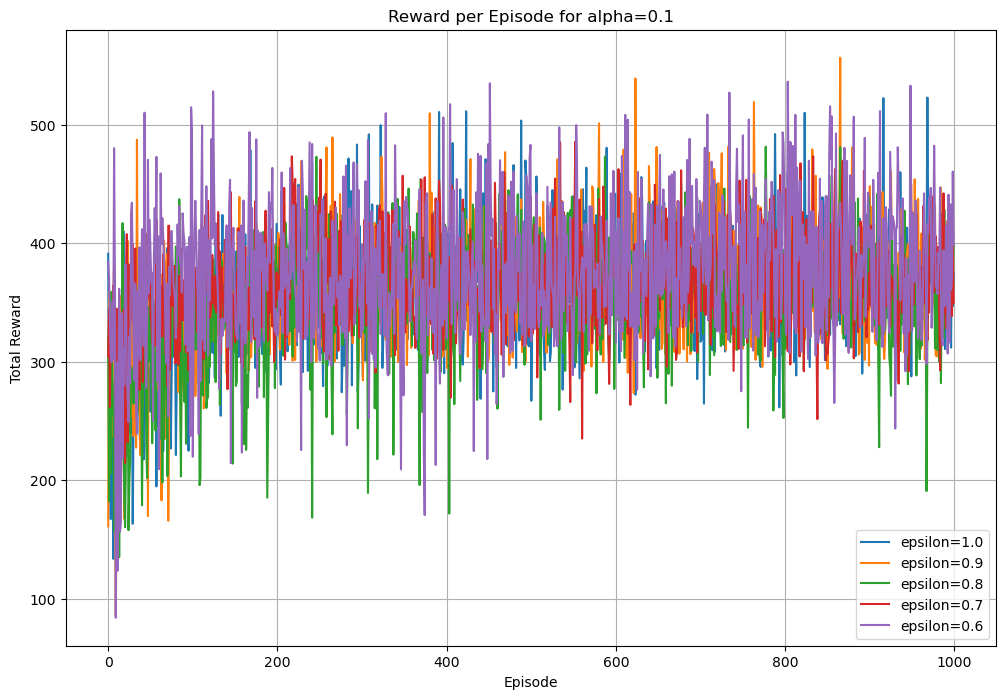

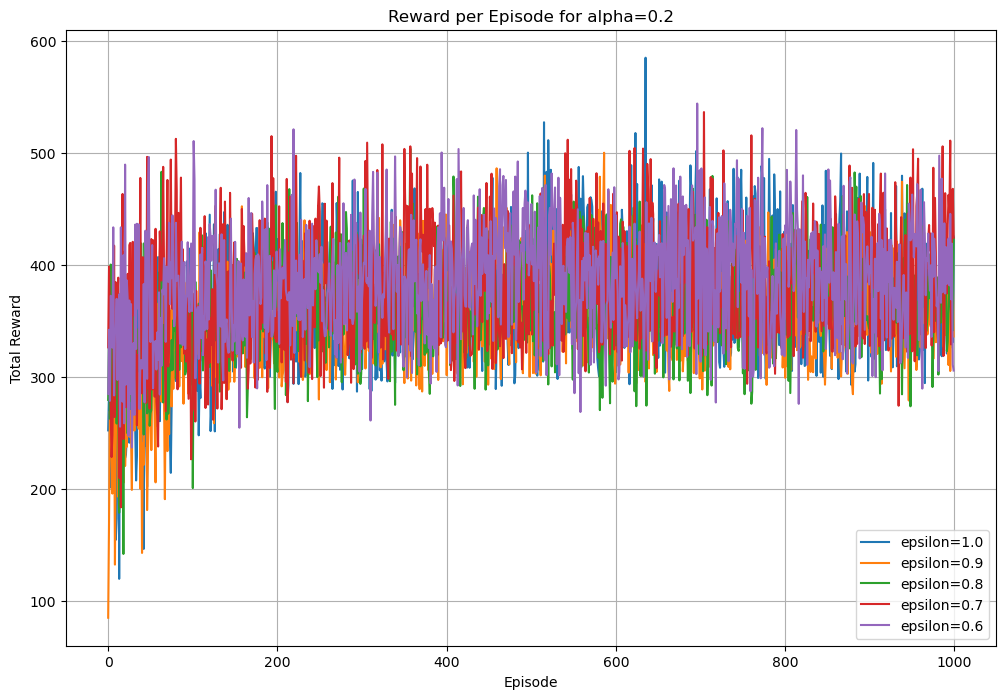

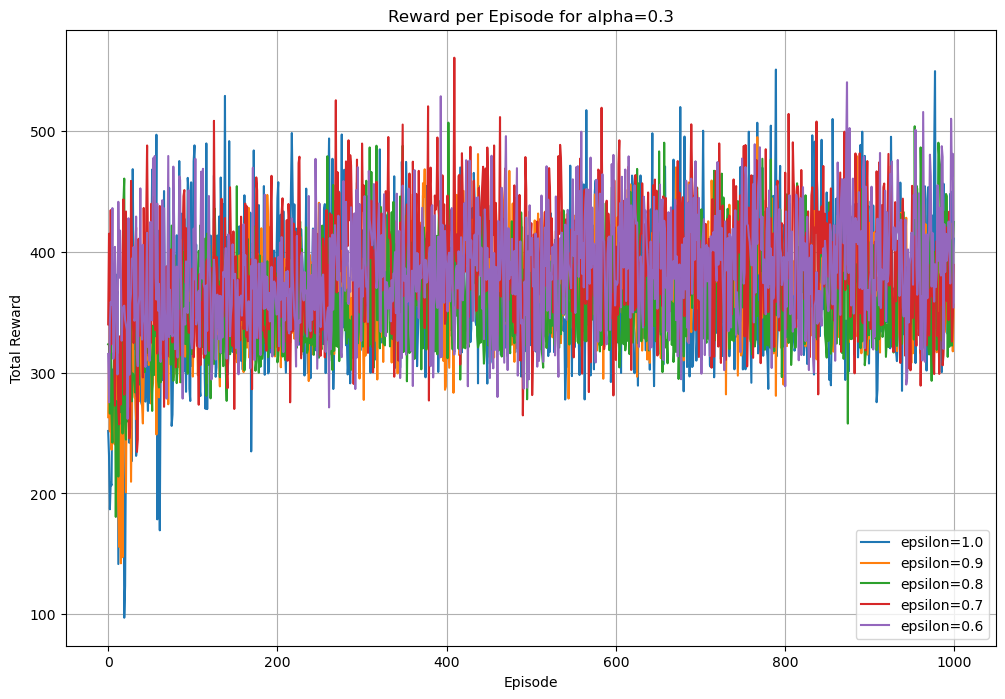

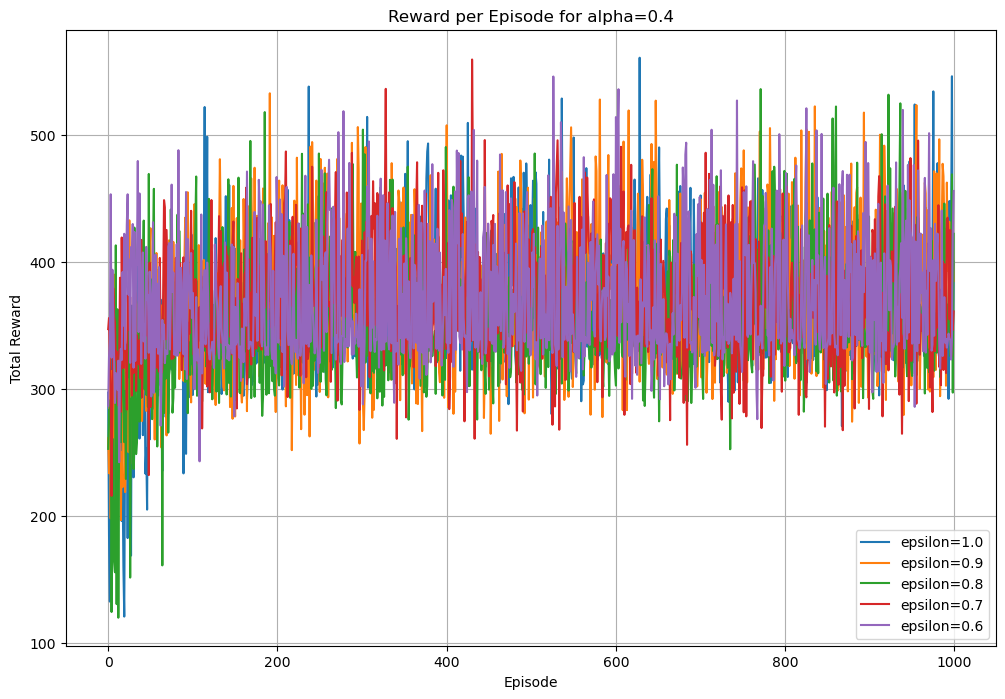

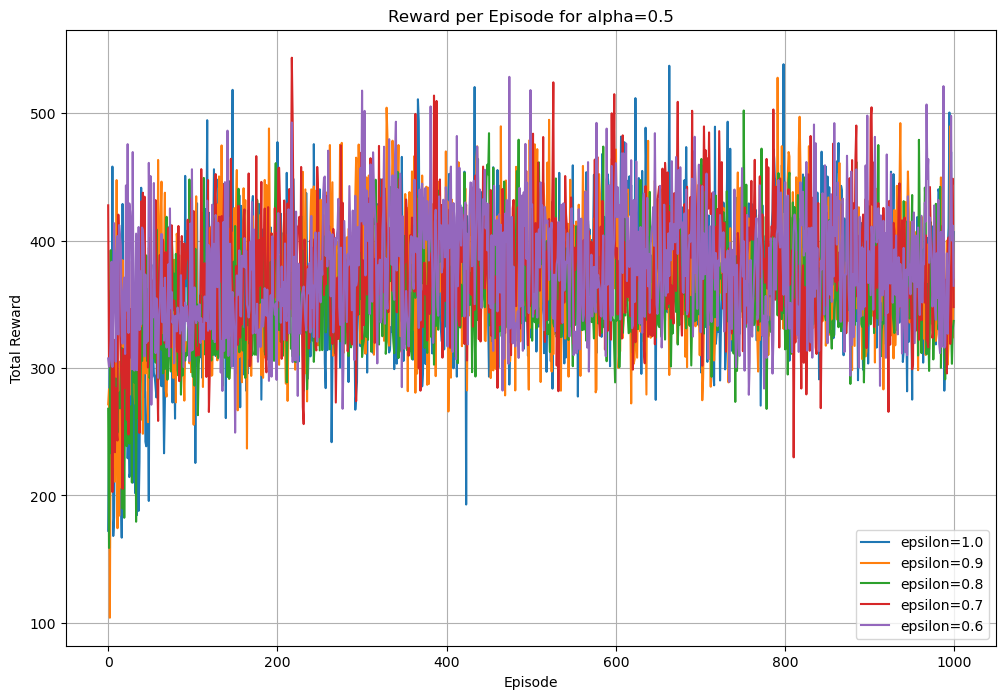

In [103]:
import numpy as np
import random
import matplotlib.pyplot as plt

class PortfolioMDP:
    def __init__(self, num_states=101, num_actions=5, initial_cash=100):
        self.num_states = num_states
        self.num_actions = num_actions
        # Creating a state space of stocks, bonds, and cash allocations, market conditions, and years left
        self.states = [(stocks, bonds, initial_cash - stocks - bonds, mc, yl)
                       for stocks in range(0, num_states, 10)
                       for bonds in range(0, num_states - stocks, 10)
                       for mc in range(3)
                       for yl in range(3)]
        self.actions = ['increase_stocks', 'decrease_stocks', 'increase_bonds', 'decrease_bonds', 'hold']
        self.state_to_index = {self.states[i]: i for i in range(len(self.states))}
        self.q_table = np.zeros((len(self.states), len(self.actions)))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def get_state_index(self, state):
        return self.state_to_index[state]

    def step(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if action == 'increase_stocks' and cash >= 10:
            stocks += 10
            cash -= 10
        elif action == 'decrease_stocks' and stocks >= 10:
            stocks -= 10
            cash += 10
        elif action == 'increase_bonds' and cash >= 10:
            bonds += 10
            cash -= 10
        elif action == 'decrease_bonds' and bonds >= 10:
            bonds -= 10
            cash += 10

        # Simulate market condition and time passing
        market_condition = random.choice([0, 1, 2])
        years_left = max(0, years_left - 1)

        next_state = (stocks, bonds, cash, market_condition, years_left)
        reward = self.calculate_reward(next_state, action)
        return next_state, reward

    def calculate_reward(self, state, action):
        stocks, bonds, cash, market_condition, years_left = state
        if market_condition == 0:  # Bearish
            return stocks * -0.02 + bonds * 0.05
        elif market_condition == 1:  # Neutral
            return stocks * 0.05 + bonds * 0.03
        else:  # Bullish
            return stocks * 0.10 + bonds * 0.01

    def learn(self, episodes=1000, max_steps=100):
        rewards_per_episode = []  # Keep track of total rewards per episode

        for episode in range(episodes):
            state = random.choice(self.states)  # Start at a random state
            total_reward = 0

            for step in range(max_steps):
                if random.uniform(0, 1) < self.epsilon:
                    action = random.choice(self.actions)  # Explore
                else:
                    state_index = self.get_state_index(state)
                    action = self.actions[np.argmax(self.q_table[state_index])]  # Exploit based on Q table

                next_state, reward = self.step(state, action)
                next_state_index = self.get_state_index(next_state)
                action_index = self.actions.index(action)

                # Q-learning update
                old_value = self.q_table[self.get_state_index(state), action_index]
                next_max = np.max(self.q_table[next_state_index])
                self.q_table[self.get_state_index(state), action_index] = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)

                total_reward += reward
                state = next_state  # Move to the next state

            rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decay epsilon

        return rewards_per_episode

# Parameters
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]  # Learning rates
epsilons = [1.0, 0.9, 0.8, 0.7, 0.6]  # Exploration rates

# Run Q-learning algorithm for each alpha and epsilon
for alpha in alphas:
    plt.figure(figsize=(12, 8))
    
    for initial_epsilon in epsilons:  # Use initial_epsilon to avoid overwriting
        mdp = PortfolioMDP()
        mdp.learning_rate = alpha
        mdp.epsilon = initial_epsilon
        
        rewards_per_episode = mdp.learn()
        
        # Plotting reward per episode for this alpha and initial_epsilon
        plt.plot(rewards_per_episode, label=f'epsilon={initial_epsilon}')

    plt.title(f'Reward per Episode for alpha={alpha}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


2079